# Comprehensiveness

In [5]:
import matplotlib.pyplot as plt
import json 
import seaborn as sns
import os 
import numpy as np
import pandas as pd

from src.calculate_comprehensiveness import load_raw,compare_topics
from src.utils import create_folders_if_not_exist

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

def list_to_dict(input_list):
    result_dict = {}
    for item in input_list:
        result_dict[item[0]] = item[1]
    return result_dict

def normalize_values(input_list):
    # Find the minimum and maximum values in the list
    min_value = min(input_list)
    max_value = max(input_list)

    # Normalize each value in the list to the range [0, 1]
    normalized_list = [(value - min_value) / (max_value - min_value) for value in input_list]

    return normalized_list

In [30]:
## Centroids
import torch
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')

def centroid_tests(topic_list):
    centroid_distance = {}
    centroid_movement = {}

    #find embeddings
    embeddings = model.encode(topic_list, convert_to_tensor=True)
    centroid = embeddings.mean(axis=0)

    # distance of each sentence from the centroid
    for i in range(len(embeddings)):
        centriod_dist = util.cos_sim(centroid,embeddings[i])
        centroid_distance[topic_list[i]] = float(centriod_dist[0,0])
    
    # movement of centroid for the absence of each sentence
    for i in range(len(embeddings)):
        embeddings_new = torch.cat((embeddings[:i], embeddings[i+1:]))
        new_centroid = embeddings_new.mean(axis=0).cpu()
        centriod_movt =  np.linalg.norm(centroid.cpu() - new_centroid)
        centroid_movement[topic_list[i]] = float(centriod_movt)

    return centroid_movement
import numpy as np 
import ast

def centroid_tests_results(path_to_base,k):
    df = pd.read_csv(path_to_base+"/Temporary_Results/Base_Results/base.csv")
    ablation_top_k_topics = {}
    centroid_test_results={}
    for topic_i in range(k):
        ablation_top_k_topics[f"Topic_{topic_i}"] = df["Representation"][topic_i+1]
        # # print(ablation_top_k_topics[f"Topic_{topic_i}"])
        # break
        centroid_test_results[f"Topic_{topic_i}"] = centroid_tests(ast.literal_eval((ablation_top_k_topics[f"Topic_{topic_i}"])))
    print("========Centroid Tests done========")
    return centroid_test_results
centroid_results = centroid_tests_results("/home/abpal/WorkFiles/Faithful-Topic-Modeling/results/Comprehensiveness/nyt_count",20)
# centroid_results

========Centroid Tests done========


In [32]:
def get_comprehensiveness_stats(path_to_base:str,topic_num:int)-> None:
    """Save Topicwise Comparison Stats to the Processed_Results directory."""

    loaded_data = load_raw(path_to_base,topic_num)
    df_basic_mapping = pd.read_csv(path_to_base+"/Temporary_Results/Base_Results/df_basic_mapping.csv")
    centroid_results = centroid_tests_results(path_to_base,topic_num)

    results = {}

    for topic_i in loaded_data.keys():
        results[topic_i] = {}
        for words in loaded_data[topic_i].keys():
            results[topic_i][words] = compare_topics(df_basic_mapping,loaded_data[topic_i][words],int(topic_i.split("_")[-1]))
            # print(centroid_results[topic_i])
            results[topic_i][words]["Centroid_Movement"] = centroid_results[topic_i][words]

    with open(f"{path_to_base}/Processed_Results/comparison_result.json", 'w') as json_file:
        json.dump(results, json_file,cls=NpEncoder)

In [35]:
def create_graph(path_to_base,topic_data,axes,words,ctf_idf_rankings,topic_number,label,key):
    total_changes = [topic_data[word][key] for word in words]
    total_changes = normalize_values(total_changes)
    # Plot total_changes for each word
    sns.lineplot(x=words, y=total_changes, marker='o',label=label)
    sns.lineplot(x=words, y=ctf_idf_rankings, marker='x',label="cTF-IDF Rankings")
    # Rotate x-axis labels sideways
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')
    axes.set_title(f'{label} - Topic {topic_number}')
    axes.set_ylabel(label)
    for i, value in enumerate(total_changes):
        axes.text(i, value, str(round(value, 2)), ha='center', va='bottom', fontsize=8)
    for i, value in enumerate(ctf_idf_rankings):
        axes.text(i, value, str(round(value, 2)), ha='center', va='bottom', fontsize=8)
    plt.savefig(path_to_base+f"/Processed_Results/graphs/Topic_{topic_number}/{label}.png")

Folder '/home/abpal/WorkFiles/Faithful-Topic-Modeling/results/Comprehensiveness/nyt_count/Processed_Results/graphs/Topic_1' already exists.


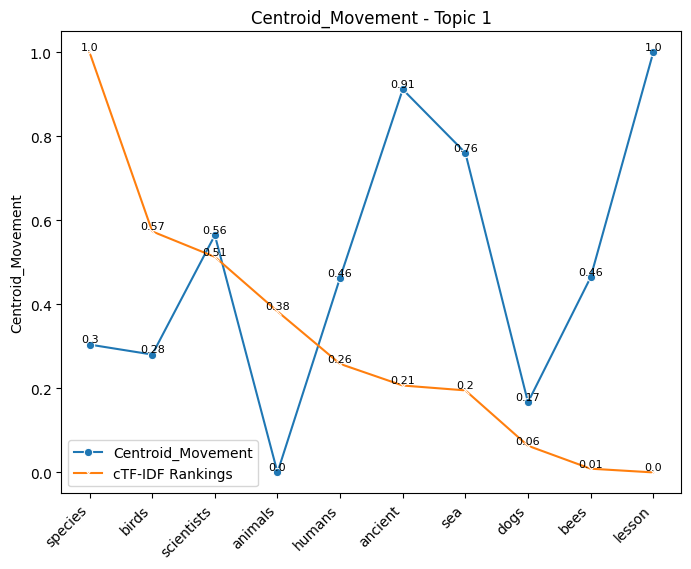

In [36]:
def create_graph_comprehensiveness(path_to_base:str,topic_number:int,choice:int) -> None : 
    """Create Graphs based on the topic_number and the choice.

    Choices:
    1. Total Change
    2. Topic Change
    3. Topic to Noise
    4. All to Noise 
    ...
    vs cTF-IDF rankings

    Args:
        path_to_base (str): _description_
        topic_number (int): _description_
        choice (int): _description_
    """
    # Create subplots
    fig, axes = plt.subplots(figsize=(8, 6))
    f = open(path_to_base+"/Processed_Results/comparison_result.json")
    data = json.load(f)
    topic_data = data[f"Topic_{topic_number}"]
    create_folders_if_not_exist(path_to_base+f"/Processed_Results/graphs/Topic_{topic_number}")
    f = open(path_to_base+"/Temporary_Results/Base_Results/ctf_idf_mappings.json")
    ctf_idf_json_topic = json.load(f)[str(topic_number)]

    # Extract word-level statistics
    words = list(ctf_idf_json_topic.keys())
    ctf_idf_rankings = [ctf_idf_json_topic[word] for word in words]
    ctf_idf_rankings = normalize_values(ctf_idf_rankings)
    topic_change = [word_data['topic_change'] for word_data in topic_data.values()]
    topic_to_noise = [word_data['topic_to_noise'] for word_data in topic_data.values()]
    
    if choice == 1 : # Total Change
        create_graph(path_to_base,topic_data,axes,words,ctf_idf_rankings,topic_number,"Total_Changes","total_changes")
            
    elif choice == 2 :  # Topic Change
        create_graph(path_to_base,topic_data,axes,words,ctf_idf_rankings,topic_number,"Topic_Changes","topic_change")
        
    elif choice == 3 :  # Topic to Noise
        create_graph(path_to_base,topic_data,axes,words,ctf_idf_rankings,topic_number,"Topic_To_Noise","topic_to_noise")
    
    elif choice == 4 : # All to Noise
        create_graph(path_to_base,topic_data,axes,words,ctf_idf_rankings,topic_number,"All_To_Noise","all_to_noise")
    
    elif choice == 5 : # Centroid
        create_graph(path_to_base,topic_data,axes,words,ctf_idf_rankings,topic_number,"Centroid_Movement","Centroid_Movement")

create_graph_comprehensiveness("/home/abpal/WorkFiles/Faithful-Topic-Modeling/results/Comprehensiveness/nyt_count",1,5)

In [47]:
import scipy

def get_topic_change_statistics(data, topic_numbers,total_docs,total_topic_docs):

    total_topic_docs = {i - 1: value for i, value in enumerate(total_topic_docs)}
    results = {}
    for idx, topic_number in enumerate(topic_numbers):
        # Extract data for the specified topic
        topic_data = data[f"Topic_{topic_number}"]

        # Extract word-level statistics
        words = list(topic_data.keys())
        total_changes = [word_data['total_changes'] for word_data in topic_data.values()]
        topic_change = [word_data['topic_change'] for word_data in topic_data.values()]
        topic_to_noise = [word_data['topic_to_noise'] for word_data in topic_data.values()]
        Centroid_Movement = [word_data['Centroid_Movement'] for word_data in topic_data.values()]
        

        # Calculate percentages
        total_changes_percentage = [value / total_docs * 100 for value in total_changes]
        topic_change_percentage = [value / total_topic_docs[topic_number] * 100 for value in topic_change]
        topic_to_noise_percentage = [value / total_topic_docs[topic_number] * 100 for value in topic_to_noise]
        Centroid_Movement_percentage = [value / total_topic_docs[topic_number] * 100 for value in Centroid_Movement]

        topic_res = {
            "Topic_Change" : {},
            "Total_Change" : {},
            "Topic_to_Noise_Change" : {},
            "Centroid_Movement" : {}
        }

        for idx,word in enumerate(words):
            topic_res['Topic_Change'][word] = topic_change_percentage[idx]
            topic_res['Total_Change'][word] = total_changes_percentage[idx]
            topic_res['Topic_to_Noise_Change'][word] = topic_to_noise_percentage[idx]
            topic_res['Centroid_Movement'][word] = Centroid_Movement_percentage[idx]
        
        results[topic_number] = topic_res    
    
    return results

def plot_correlations(correlations_):
    # Your list of values
    values = correlations_

    # Generate x values (assuming each value corresponds to a point on the x-axis)
    x_values = range(len(values))

    # Create a DataFrame for Seaborn
    data = {'Index': x_values, 'Values': values}
    df = pd.DataFrame(data)

    # Create scatter plot using Seaborn
    sns.scatterplot(x='Index', y='Values', data=df)

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.title('Scatter Plot of Correlations')

    # Show the plot
    plt.show()

def create_overall_stats(path_to_base:str,k:int,choice):
    # Create subplots
    # fig, axes = plt.subplots(figsize=(8, 6))
    f = open(path_to_base+"/Processed_Results/comparison_result.json")
    data = json.load(f)
    correlations_,p_values = [],[]

    # Step 1: Load DataFrame from CSV
    df = pd.read_csv(path_to_base+"/Temporary_Results/Base_Results/base.csv")

    # Step 2: Load a specific column into a list
    column_name = "Count"  # Replace with the actual name of the column
    column_list = df[column_name].tolist()
    df_basic_mapping = pd.read_csv(path_to_base+"/Temporary_Results/Base_Results/df_basic_mapping.csv")

    topic_change_stat = get_topic_change_statistics(
        data = data, 
        topic_numbers = range(k),
        total_docs =  len(df_basic_mapping),
        total_topic_docs = column_list,
    )
    print(topic_change_stat)
    create_folders_if_not_exist(path_to_base+f"/Processed_Results/graphs/spearman_rho")
    f = open(path_to_base+"/Temporary_Results/Base_Results/ctf_idf_mappings.json")
    ctf_idf_json = json.load(f)

    for topic_number in range(k):
        ctf_idf_json_topic = ctf_idf_json[str(topic_number)]

        words = list(ctf_idf_json_topic.keys())
        ctf_idf_rankings = [ctf_idf_json_topic[word] for word in words]
        # print(f'Numbers for key {i}: {numbers_for_key}')
        x = ctf_idf_rankings

        # get the ranks based on percentage of topics changed per representative word
        y = list(topic_change_stat[topic_number][choice].values())
        
        rho, p_value = scipy.stats.spearmanr(x, y)
        correlations_.append(rho)
        p_values.append(p_value)
    return (correlations_,p_values)

def correlation_stats(correlations, p_values):
    overall_corr_avg = sum(correlations) / len(correlations)
    overall_p_val_avg = sum(p_values) / len(p_values)

    filtered_data = [(corr, p_val) for corr, p_val in zip(correlations, p_values) if p_val > 0.4]
    filtered_corr_avg = sum(corr for corr, _ in filtered_data) / len(filtered_data) if filtered_data else None
    filtered_p_val_avg = sum(p_val for _, p_val in filtered_data) / len(filtered_data) if filtered_data else None

    return {
        'overall_corr_avg': overall_corr_avg,
        'overall_p_val_avg': overall_p_val_avg,
        'filtered_corr_avg': filtered_corr_avg,
        'filtered_p_val_avg': filtered_p_val_avg
    }

# # Example usage
# correlations = [-0.5215116512688716, 0.10770068750711072, 0.15244185832977605, 0.04878139466552833, 0.4690255313502149]
# p_values = [0.12211083031892074, 0.7671185519911621, 0.6741752533023246, 0.8935442648854668, 0.17147933684385333]

# result = correlation_stats(correlations, p_values)
# print(result)


c,p = create_overall_stats("/home/abpal/WorkFiles/Faithful-Topic-Modeling/results/Comprehensiveness/nyt_count",20,"Topic_Change")

Folder '/home/abpal/WorkFiles/Faithful-Topic-Modeling/results/Comprehensiveness/nyt_count/Processed_Results/graphs/spearman_rho' already exists.
{0: {'Topic_Change': {'simple': 14.698162729658792, 'this': 18.635170603674542, 'dish': 14.960629921259844, 'meal': 14.698162729658792, 'soup': 17.322834645669293, 'recipes': 14.960629921259844, 'restaurant': 19.94750656167979, 'dinner': 16.79790026246719, 'chef': 16.79790026246719, 'dishes': 19.94750656167979}, 'Total_Change': {'simple': 15.782888465204959, 'this': 15.92588179218303, 'dish': 15.151334604385127, 'meal': 15.437321258341278, 'soup': 16.009294566253573, 'recipes': 15.52073403241182, 'restaurant': 15.449237368922782, 'dinner': 15.592230695900858, 'chef': 15.455195424213535, 'dishes': 15.502859866539561}, 'Topic_to_Noise_Change': {'simple': 14.698162729658792, 'this': 18.635170603674542, 'dish': 14.960629921259844, 'meal': 14.435695538057743, 'soup': 17.322834645669293, 'recipes': 14.960629921259844, 'restaurant': 19.94750656167979

In [48]:
result = correlation_stats(c, p)
result

{'overall_corr_avg': -0.13900714202681136,
 'overall_p_val_avg': 0.4405405223612996,
 'filtered_corr_avg': -0.059684318180383236,
 'filtered_p_val_avg': 0.7098296196842059}

In [51]:
c,p = create_overall_stats("/home/abpal/WorkFiles/Faithful-Topic-Modeling/results/Comprehensiveness/20newsgroup_count",20,"Topic_Change")

Folder '/home/abpal/WorkFiles/Faithful-Topic-Modeling/results/Comprehensiveness/20newsgroup_count/Processed_Results/graphs/spearman_rho' already exists.
{0: {'Topic_Change': {'players': 7.6190476190476195, 'games': 6.666666666666667, 'his': 6.122448979591836, 'baseball': 8.299319727891156, 'team': 6.122448979591836, 'year': 5.034013605442176, 'won': 6.530612244897959, 'game': 7.6190476190476195, 'hit': 5.170068027210884, 'he': 9.523809523809524}, 'Total_Change': {'players': 15.133184760691924, 'games': 15.382574551628995, 'his': 15.71155682903534, 'baseball': 15.398493048922848, 'team': 15.371962220099755, 'year': 15.520534861509075, 'won': 15.902578796561603, 'game': 15.366656054335138, 'hit': 15.679719834447628, 'he': 18.54504934734161}, 'Topic_to_Noise_Change': {'players': 7.6190476190476195, 'games': 6.666666666666667, 'his': 6.122448979591836, 'baseball': 8.027210884353742, 'team': 5.986394557823129, 'year': 5.034013605442176, 'won': 6.530612244897959, 'game': 7.6190476190476195, 

/home/abpal/miniconda3/envs/bertopic_env/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [56]:
import numpy as np

def remove_nan_entries(list1, list2):
    # Find indices where the first list has nan values
    nan_indices = np.isnan(list1)

    # Use boolean indexing to filter out nan entries from both lists
    filtered_list1 = [val for i, val in enumerate(list1) if not nan_indices[i]]
    filtered_list2 = [val for i, val in enumerate(list2) if not nan_indices[i]]

    return filtered_list1, filtered_list2

c,p = remove_nan_entries(c,p)

In [57]:
result = correlation_stats(c, p)
result

{'overall_corr_avg': 0.03436363313350102,
 'overall_p_val_avg': 0.6001099393923506,
 'filtered_corr_avg': -0.025671889673129136,
 'filtered_p_val_avg': 0.7480303188612757}

## NYT

In [67]:
ablation_base = "/home/abpal/WorkFiles/Faithful-Topic-Modeling/results/Comprehensiveness/nyt_count"
k = 20

get_comprehensiveness_stats(ablation_base,k)

========Centroid Tests done========


In [66]:
# create_graph_comprehensiveness(ablation_base,np.random.randint(0,19),5)

In [68]:
c,p = create_overall_stats(ablation_base,20,"Topic_Change")
c,p = remove_nan_entries(c,p)
correlation_stats(c,p)

Folder '/home/abpal/WorkFiles/Faithful-Topic-Modeling/results/Comprehensiveness/nyt_count/Processed_Results/graphs/spearman_rho' already exists.
{0: {'Topic_Change': {'simple': 14.698162729658792, 'this': 18.635170603674542, 'dish': 14.960629921259844, 'meal': 14.698162729658792, 'soup': 17.322834645669293, 'recipes': 14.960629921259844, 'restaurant': 19.94750656167979, 'dinner': 16.79790026246719, 'chef': 16.79790026246719, 'dishes': 19.94750656167979}, 'Total_Change': {'simple': 15.782888465204959, 'this': 15.92588179218303, 'dish': 15.151334604385127, 'meal': 15.437321258341278, 'soup': 16.009294566253573, 'recipes': 15.52073403241182, 'restaurant': 15.449237368922782, 'dinner': 15.592230695900858, 'chef': 15.455195424213535, 'dishes': 15.502859866539561}, 'Topic_to_Noise_Change': {'simple': 14.698162729658792, 'this': 18.635170603674542, 'dish': 14.960629921259844, 'meal': 14.435695538057743, 'soup': 17.322834645669293, 'recipes': 14.960629921259844, 'restaurant': 19.94750656167979

{'overall_corr_avg': -0.13900714202681136,
 'overall_p_val_avg': 0.4405405223612996,
 'filtered_corr_avg': -0.059684318180383236,
 'filtered_p_val_avg': 0.7098296196842059}

In [69]:
c,p = create_overall_stats(ablation_base,20,"Centroid_Movement")
c,p = remove_nan_entries(c,p)
correlation_stats(c,p)

Folder '/home/abpal/WorkFiles/Faithful-Topic-Modeling/results/Comprehensiveness/nyt_count/Processed_Results/graphs/spearman_rho' already exists.
{0: {'Topic_Change': {'simple': 14.698162729658792, 'this': 18.635170603674542, 'dish': 14.960629921259844, 'meal': 14.698162729658792, 'soup': 17.322834645669293, 'recipes': 14.960629921259844, 'restaurant': 19.94750656167979, 'dinner': 16.79790026246719, 'chef': 16.79790026246719, 'dishes': 19.94750656167979}, 'Total_Change': {'simple': 15.782888465204959, 'this': 15.92588179218303, 'dish': 15.151334604385127, 'meal': 15.437321258341278, 'soup': 16.009294566253573, 'recipes': 15.52073403241182, 'restaurant': 15.449237368922782, 'dinner': 15.592230695900858, 'chef': 15.455195424213535, 'dishes': 15.502859866539561}, 'Topic_to_Noise_Change': {'simple': 14.698162729658792, 'this': 18.635170603674542, 'dish': 14.960629921259844, 'meal': 14.435695538057743, 'soup': 17.322834645669293, 'recipes': 14.960629921259844, 'restaurant': 19.94750656167979

{'overall_corr_avg': 0.1348641668182502,
 'overall_p_val_avg': 0.2867282375660659,
 'filtered_corr_avg': -0.022222222222222216,
 'filtered_p_val_avg': 0.598831031322774}

# 20 NewsGroup

In [70]:
ablation_base = "/home/abpal/WorkFiles/Faithful-Topic-Modeling/results/Comprehensiveness/20newsgroup_count"
k = 100

get_comprehensiveness_stats(ablation_base,k)

========Centroid Tests done========


Folder '/home/abpal/WorkFiles/Faithful-Topic-Modeling/results/Comprehensiveness/20newsgroup_count/Processed_Results/graphs/Topic_74' created successfully.


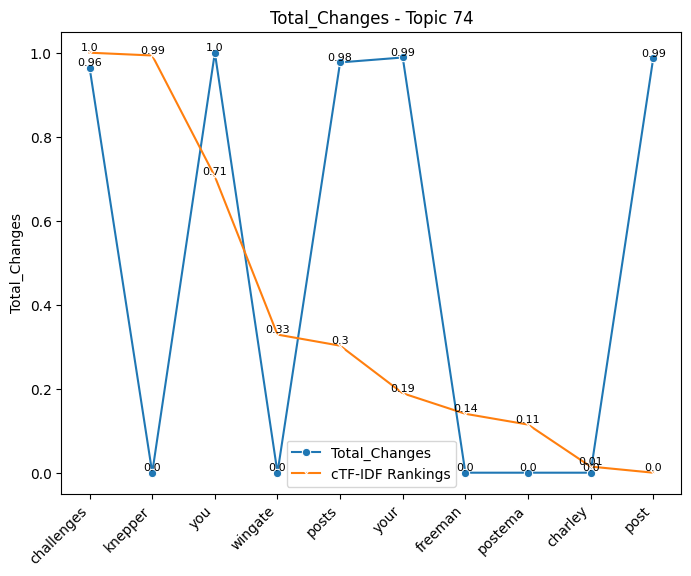

In [71]:
create_graph_comprehensiveness(ablation_base,np.random.randint(0,100),1)

In [72]:
c,p = create_overall_stats(ablation_base,20,"Topic_Change")
c,p = remove_nan_entries(c,p)
correlation_stats(c,p)

Folder '/home/abpal/WorkFiles/Faithful-Topic-Modeling/results/Comprehensiveness/20newsgroup_count/Processed_Results/graphs/spearman_rho' already exists.
{0: {'Topic_Change': {'players': 7.6190476190476195, 'games': 6.666666666666667, 'his': 6.122448979591836, 'baseball': 8.299319727891156, 'team': 6.122448979591836, 'year': 5.034013605442176, 'won': 6.530612244897959, 'game': 7.6190476190476195, 'hit': 5.170068027210884, 'he': 9.523809523809524}, 'Total_Change': {'players': 15.133184760691924, 'games': 15.382574551628995, 'his': 15.71155682903534, 'baseball': 15.398493048922848, 'team': 15.371962220099755, 'year': 15.520534861509075, 'won': 15.902578796561603, 'game': 15.366656054335138, 'hit': 15.679719834447628, 'he': 18.54504934734161}, 'Topic_to_Noise_Change': {'players': 7.6190476190476195, 'games': 6.666666666666667, 'his': 6.122448979591836, 'baseball': 8.027210884353742, 'team': 5.986394557823129, 'year': 5.034013605442176, 'won': 6.530612244897959, 'game': 7.6190476190476195, 

/home/abpal/miniconda3/envs/bertopic_env/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


{'overall_corr_avg': 0.0446020422902179,
 'overall_p_val_avg': 0.6163510102629416,
 'filtered_corr_avg': -0.0117769058175848,
 'filtered_p_val_avg': 0.7700717721856493}

In [73]:
c,p = create_overall_stats(ablation_base,20,"Centroid_Movement")
c,p = remove_nan_entries(c,p)
correlation_stats(c,p)

Folder '/home/abpal/WorkFiles/Faithful-Topic-Modeling/results/Comprehensiveness/20newsgroup_count/Processed_Results/graphs/spearman_rho' already exists.
{0: {'Topic_Change': {'players': 7.6190476190476195, 'games': 6.666666666666667, 'his': 6.122448979591836, 'baseball': 8.299319727891156, 'team': 6.122448979591836, 'year': 5.034013605442176, 'won': 6.530612244897959, 'game': 7.6190476190476195, 'hit': 5.170068027210884, 'he': 9.523809523809524}, 'Total_Change': {'players': 15.133184760691924, 'games': 15.382574551628995, 'his': 15.71155682903534, 'baseball': 15.398493048922848, 'team': 15.371962220099755, 'year': 15.520534861509075, 'won': 15.902578796561603, 'game': 15.366656054335138, 'hit': 15.679719834447628, 'he': 18.54504934734161}, 'Topic_to_Noise_Change': {'players': 7.6190476190476195, 'games': 6.666666666666667, 'his': 6.122448979591836, 'baseball': 8.027210884353742, 'team': 5.986394557823129, 'year': 5.034013605442176, 'won': 6.530612244897959, 'game': 7.6190476190476195, 

{'overall_corr_avg': -0.06909090909090909,
 'overall_p_val_avg': 0.5461921024659577,
 'filtered_corr_avg': -0.08121212121212121,
 'filtered_p_val_avg': 0.6496815294688434}

# Wiki

In [74]:
ablation_base = "/home/abpal/WorkFiles/Faithful-Topic-Modeling/results/Comprehensiveness/wiki_count"
k = 100

get_comprehensiveness_stats(ablation_base,k)

========Centroid Tests done========


Folder '/home/abpal/WorkFiles/Faithful-Topic-Modeling/results/Comprehensiveness/wiki_count/Processed_Results/graphs/Topic_6' created successfully.


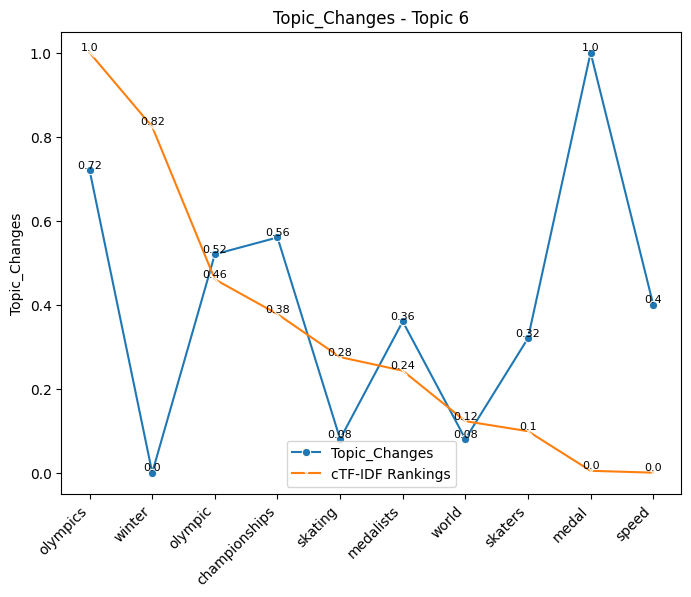

In [75]:
create_graph_comprehensiveness(ablation_base,np.random.randint(0,100),np.random.randint(1,4))

In [76]:
c,p = create_overall_stats(ablation_base,20,"Topic_Change")
c,p = remove_nan_entries(c,p)
correlation_stats(c,p)

Folder '/home/abpal/WorkFiles/Faithful-Topic-Modeling/results/Comprehensiveness/wiki_count/Processed_Results/graphs/spearman_rho' already exists.
{0: {'Topic_Change': {'album': 29.559748427672954, 'songs': 30.60796645702306, 'vocals': 29.559748427672954, 'band': 30.60796645702306, 'albums': 27.044025157232703, 'released': 32.075471698113205, 'song': 30.398322851153043, 'guitar': 29.140461215932913, 'records': 32.70440251572327, 'music': 31.865828092243188}, 'Total_Change': {'album': 13.29, 'songs': 13.36, 'vocals': 13.459999999999999, 'band': 13.19, 'albums': 12.53, 'released': 13.44, 'song': 13.13, 'guitar': 13.3, 'records': 13.639999999999999, 'music': 13.530000000000001}, 'Topic_to_Noise_Change': {'album': 29.559748427672954, 'songs': 30.60796645702306, 'vocals': 29.140461215932913, 'band': 30.60796645702306, 'albums': 26.62473794549266, 'released': 31.865828092243188, 'song': 30.18867924528302, 'guitar': 28.511530398322847, 'records': 32.075471698113205, 'music': 31.865828092243188

{'overall_corr_avg': -0.01036455892769086,
 'overall_p_val_avg': 0.4131516685170914,
 'filtered_corr_avg': 0.05108521165997922,
 'filtered_p_val_avg': 0.6831943031314791}

In [77]:
c,p = create_overall_stats(ablation_base,20,"Centroid_Movement")
c,p = remove_nan_entries(c,p)
correlation_stats(c,p)

Folder '/home/abpal/WorkFiles/Faithful-Topic-Modeling/results/Comprehensiveness/wiki_count/Processed_Results/graphs/spearman_rho' already exists.
{0: {'Topic_Change': {'album': 29.559748427672954, 'songs': 30.60796645702306, 'vocals': 29.559748427672954, 'band': 30.60796645702306, 'albums': 27.044025157232703, 'released': 32.075471698113205, 'song': 30.398322851153043, 'guitar': 29.140461215932913, 'records': 32.70440251572327, 'music': 31.865828092243188}, 'Total_Change': {'album': 13.29, 'songs': 13.36, 'vocals': 13.459999999999999, 'band': 13.19, 'albums': 12.53, 'released': 13.44, 'song': 13.13, 'guitar': 13.3, 'records': 13.639999999999999, 'music': 13.530000000000001}, 'Topic_to_Noise_Change': {'album': 29.559748427672954, 'songs': 30.60796645702306, 'vocals': 29.140461215932913, 'band': 30.60796645702306, 'albums': 26.62473794549266, 'released': 31.865828092243188, 'song': 30.18867924528302, 'guitar': 28.511530398322847, 'records': 32.075471698113205, 'music': 31.865828092243188

{'overall_corr_avg': -0.07636363636363636,
 'overall_p_val_avg': 0.6412947839749676,
 'filtered_corr_avg': -0.05454545454545453,
 'filtered_p_val_avg': 0.7282085945065003}

# keybert_nyt

In [78]:
ablation_base = "/home/abpal/WorkFiles/Faithful-Topic-Modeling/results/Comprehensiveness/wiki_count"
k = 100

get_comprehensiveness_stats(ablation_base,k)
c,p = create_overall_stats(ablation_base,20,"Topic_Change")
c,p = remove_nan_entries(c,p)
print(correlation_stats(c,p))

c,p = create_overall_stats(ablation_base,20,"Centroid_Movement")
c,p = remove_nan_entries(c,p)
print(correlation_stats(c,p))

========Centroid Tests done========
Folder '/home/abpal/WorkFiles/Faithful-Topic-Modeling/results/Comprehensiveness/wiki_count/Processed_Results/graphs/spearman_rho' already exists.
{0: {'Topic_Change': {'album': 29.559748427672954, 'songs': 30.60796645702306, 'vocals': 29.559748427672954, 'band': 30.60796645702306, 'albums': 27.044025157232703, 'released': 32.075471698113205, 'song': 30.398322851153043, 'guitar': 29.140461215932913, 'records': 32.70440251572327, 'music': 31.865828092243188}, 'Total_Change': {'album': 13.29, 'songs': 13.36, 'vocals': 13.459999999999999, 'band': 13.19, 'albums': 12.53, 'released': 13.44, 'song': 13.13, 'guitar': 13.3, 'records': 13.639999999999999, 'music': 13.530000000000001}, 'Topic_to_Noise_Change': {'album': 29.559748427672954, 'songs': 30.60796645702306, 'vocals': 29.140461215932913, 'band': 30.60796645702306, 'albums': 26.62473794549266, 'released': 31.865828092243188, 'song': 30.18867924528302, 'guitar': 28.511530398322847, 'records': 32.07547169

# keybert_20newsgroup

# keybert_wiki

# Sufficiency